# **To reproduce study results use cellrank required package versions**

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import math
import seaborn as sns
import os
# %config IPCompleter.greedy=True
%load_ext autoreload
%autoreload 2

sc.settings.verbosity = 0
sc.logging.print_header()
sns.set_context("paper")

scanpy==1.9.1 anndata==0.7.6 umap==0.5.1 numpy==1.20.3 scipy==1.7.1 pandas==1.3.3 scikit-learn==1.0 statsmodels==0.13.0rc0 pynndescent==0.5.4


In [2]:
# scanpy==1.6.0 anndata==0.7.4 umap==0.4.3 numpy==1.18.2 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.10.1 python-igraph==0.8.0 louvain==0.6.1 leidenalg==0.8.0

In [3]:
# import local module containing misc code, helps keep notebooks clean from commonly used functions
import new_misc_code as nmc 

In [4]:
import scvelo as scv
scv.logging.print_version()

Running scvelo 0.2.4 (python 3.7.6) on 2022-08-16 15:09.


ERROR: XMLRPC request failed [code: -32500]
RuntimeError: PyPI's XMLRPC API is currently disabled due to unmanageable load and will be deprecated in the near future. See https://status.python.org/ for more information.


### **Read in loom adata**

In [6]:
# loom adata from 17__loom-file-preprocessing.ipynb
loom_file_nm = "../data/whole-tissue_with-looms.h5ad"
adata = sc.read( loom_file_nm)

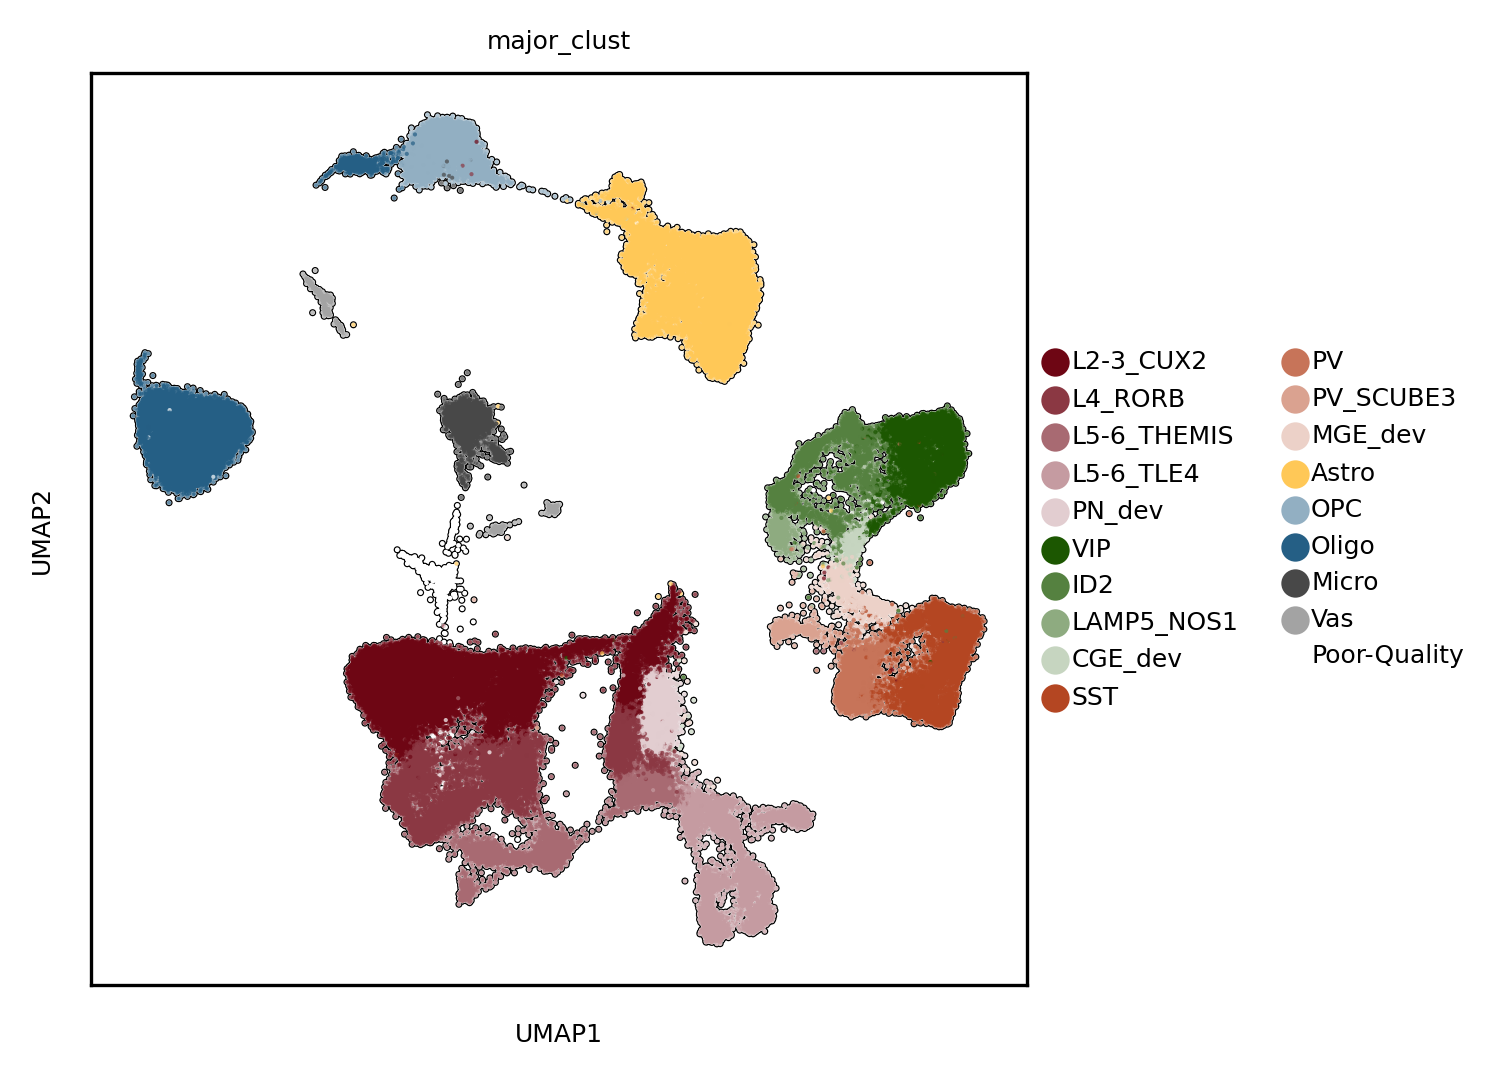

In [28]:
# scv.set_figure_params('scvelo')
sc.settings.set_figure_params( dpi=150, fontsize=6)
sc.pl.embedding( adata, basis='umap', color=['major_clust'], legend_fontsize=6, 
                 add_outline=True, size=4, legend_fontoutline=0.2)

## **Compute CytoTrace values**

In [29]:
# use PCs that explain 50% of variation, see 03__whole-tissue_clustering.ipynb 
pcs = 365

In [30]:
def plot_kernel( adata):
    scv.pl.velocity_embedding_stream( adata, color="lightgrey", vkey="T_fwd", basis="umap", 
                                      legend_loc='none', figsize=(6,6), cmap='viridis',
                                      linewidth=4.0, arrow_style='->')
    return

In [31]:
### Code and comments below were copied over from a cellrank CytoTrace example, see:
### https://cellrank.readthedocs.io/en/stable/api/cellrank.tl.kernels.CytoTRACEKernel.html
# CytoTRACE by default uses imputed data - a simple way to compute KNN-imputed data is to use scVelo's moments
# function. However, note that this function expects `spliced` counts because it's designed for RNA velocity,
# so we're using a simple hack here:
# if 'spliced' not in adata.layers or 'unspliced' not in adata.layers:

# copy actual un/spliced counts to safe place
adata.layers['loom_spliced'] = adata.layers['spliced'].copy()
adata.layers['loom_unspliced'] = adata.layers['unspliced'].copy()

# set UMI counts to spliced and unspliced layers
adata.layers['spliced'] = adata.X.copy()
adata.layers['unspliced'] = adata.X.copy()

# compute KNN-imputation using scVelo's moments function
scv.pp.moments( adata, n_pcs=pcs, n_neighbors=25)

from cellrank.tl.kernels import CytoTRACEKernel
ctk = CytoTRACEKernel( adata)
# ctk.compute_transition_matrix( threshold_scheme="soft", nu=0.5, n_jobs=20)

# copy real un/spliced counts back in layers 
adata.layers['spliced'] = adata.layers['loom_spliced']
adata.layers['unspliced'] = adata.layers['loom_unspliced']

computing neighbors
    finished (0:00:39) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:02:24) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [32]:
# ctk.compute_projection( basis="umap")

In [33]:
# plot_kernel( adata)

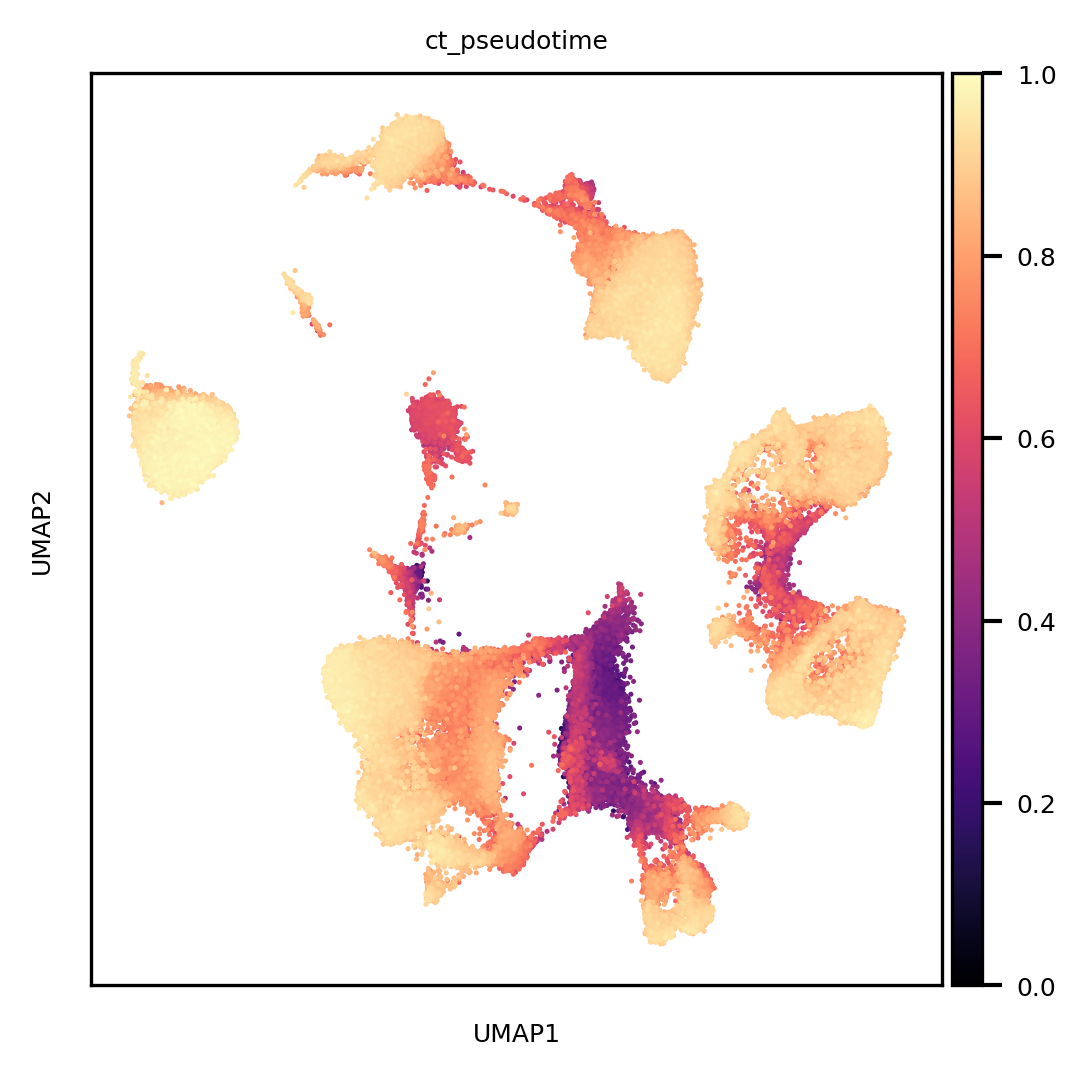

In [34]:
sc.pl.embedding( adata, color="ct_pseudotime", basis="umap", cmap='magma', size=6)

## **scVelo**

In [46]:
scv.settings.verbosity = 3
scv.set_figure_params('scvelo')  # for beautified visualization

In [47]:
scv.pp.filter_and_normalize( adata, min_shared_counts=5, n_top_genes=1500)

Filtered out 9104 genes that are detected 5 counts (shared).
Normalized count data: spliced, unspliced.
Extracted 1500 highly variable genes.


In [48]:
adata.shape, adata.layers['spliced'].shape

((132229, 1500), (132229, 1500))

In [49]:
def plot_vel( nn, adata=adata, n_pcs=pcs, mode='deterministic', basis='umap', cc=['major_clust']):
#     scv.pp.moments( adata, n_pcs=n_pcs, n_neighbors=25)
    scv.pp.neighbors( adata, n_neighbors=nn, n_pcs=n_pcs)
    adata.layers['Ms'] = scv.utils.get_moments( adata, layer='spliced')
    adata.layers['Mu'] = scv.utils.get_moments( adata, layer='unspliced')
    scv.tl.velocity( adata, mode=mode)
    scv.tl.velocity_graph( adata)
    scv.pl.velocity_embedding_stream( adata, basis=basis, color=cc, figsize=(8,8))
    return

In [ ]:
# this will take a few hours to run
plot_vel( 50, adata=adata, mode='stochastic', basis='umap')

computing neighbors
    finished (0:00:44) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
    finished (0:01:58) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/32 cores)
or disable the progress bar using `show_progress_bar=False`.


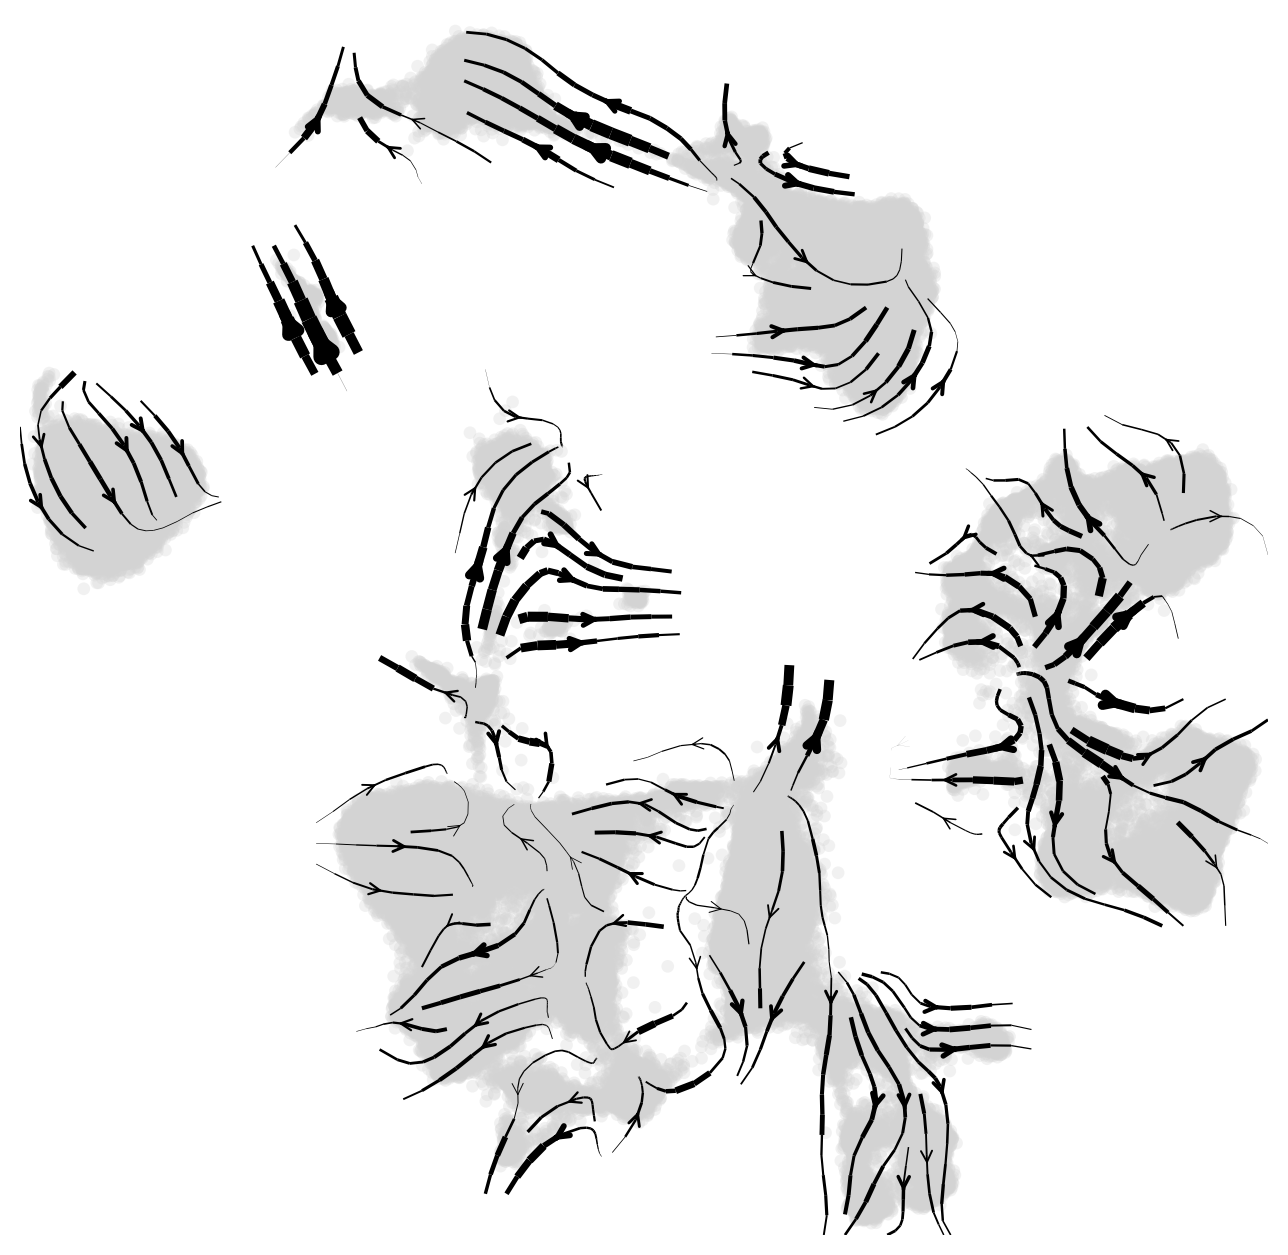

In [52]:
scv.pl.velocity_embedding_stream( adata, color="lightgrey", basis="umap", 
                                      legend_loc='none', figsize=(8,8), cmap='viridis',
                                      linewidth=3.0, arrow_style='->')